Let's check the elbow in Conifer and possible even explore other methods. Here's the original plot they spit out:

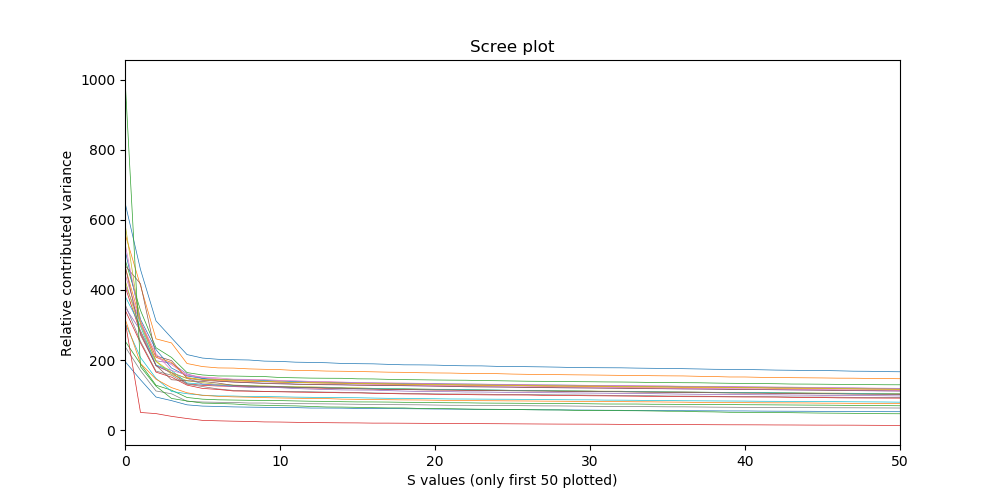

I'd go with 5 by eye, but let's see if we can do better. First, let's check for outliers in SD:

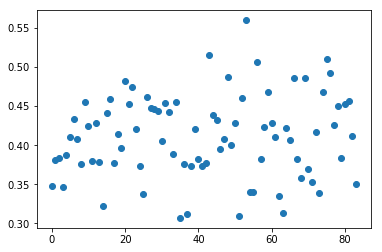

In [2]:
%matplotlib inline

import pylab as pl

fid = open('/data/sudregp/cnv/conifer84/sd_values.txt', 'r')
sds = [float(line.rstrip().split('\t')[1]) for line in fid]
fid.close()
pl.plot(sds, 'o')

Hum, maybe the top-most point... let's see if we can quantify it:

In [3]:
import numpy as np
[s for s in sds if s > (np.mean(sds) + 3*np.std(sds)) or 
                   s < (np.mean(sds) - 3*np.std(sds)) ]

[]

Not really... OK, let's keep them all. Now, for the pct explained plot:

In [8]:
import pandas as pd

df = pd.read_table('/data/sudregp/cnv/conifer84/singular_values.txt',
                   header=None, index_col=0)
df.shape

(24, 84)

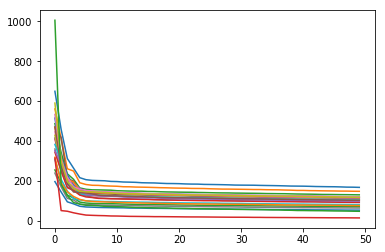

In [13]:
fig = pl.plot(range(50), np.array(df)[:, :50].T)

OK, now we zoom in:

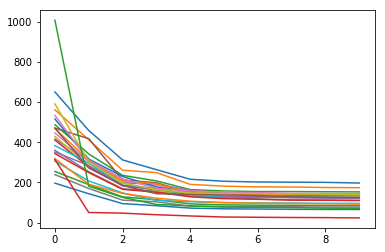

In [14]:
fig = pl.plot(range(10), np.array(df)[:, :10].T)

OK, so 4 should be enough. Let's re-run it:

In [ ]:
#  in terminal
cd ~/data/cnv/conifer84
module load python
source activate my_py2.7

probes=/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py analyze \
    --probes $probes \
    --rpkm_dir ./RPKM/ --output analysis.hdf5 --svd 4 \
    --write_svals singular_values.txt --plot_scree screeplot.png \
    --write_sd sd_values.txt
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py call \
    --input analysis.hdf5 --output calls.txt

I'm gonna go ahead and export this in case we want to run another algorithms on it later:

In [ ]:
#  in terminal
mkdir export_svdzrpkm
python /data/NCR_SBRB/software/conifer_v0.2.2/conifer.py export \
    --input analysis.hdf5 --output ./export_svdzrpkm/

Alright, now time to classify all the called CNVs using the default threshold method:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
import glob
ped_files = ['/data/sudregp/multiplex_simplex/simplex.ped']
wes_prefix = ['CLIA', 'CCGO', 'WPS']
# fid = open('/home/sudregp/data/multiplex_simplex/samples_simplex_all.txt', 'r')
# exclude_list = [line.rstrip() for line in fid]
# fid.close()

# no controls/affected pair for comparison
exclude_list = ['CLIA_400165', 'CLIA_400164', 'CLIA_400155', 'CLIA_400146',
                'CLIA_400145', 'CLIA_400126', 'CLIA_400207', 'CLIA_400208',
                'CLIA_400209']
# missing one parent
exclude_list += ['CLIA_400169', 'CLIA_400168']
# family 9030
exclude_list += ['CCGO_800978', 'CCGO_800977', 'CCGO_800976', 'CCGO_800979',
                 'CCGO_800980', 'CLIA_400067']

trios = []
affected = []
controls = []
samples = []
famids = []
for ped_file in ped_files:
    fid = open(ped_file, 'r')
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        # if the current ID and its parents have WES data, and the sample is 
        # not in yet
        if (fa.split('_')[0] in wes_prefix and
            mo.split('_')[0] in wes_prefix and
            sid.split('_')[0] in wes_prefix and
            sid not in samples and
            (sid not in exclude_list or fa not in exclude_list or mo not in exclude_list)):
            fam = {}
            fam['child'] = sid
            if aff == '1':
                affected.append(sid)
            else:
                controls.append(sid)
            fam['father'] = fa
            fam['mother'] = mo
            fam['famid'] = famid
            trios.append(fam)
            samples += [sid, fa, mo]
            famids.append(famid)
    fid.close()
samples = set(samples)
famids = set(famids)
kids = set(affected + controls)
good_kids = kids

print 'Unique samples:', len(samples)
print 'Unique families:', len(famids)
print 'Unique children:', len(kids)

Unique samples: 84
Unique families: 19
Unique children: 46


In [3]:
def classify_cnvs(cnvs, trios):
    inherited = {}
    denovo = {}
    for trio in trios:
        inherited[trio['child']] = []
        denovo[trio['child']] = []

    # need to filter in chr and type first because ranges repeat for every chr,
    # and inheritance is only true for the same type of CNV
    for chr in ['chr%d' % d for d in range(1, 23)]:
        for cnvtype in ['dup', 'del']:
            for trio in trios:
                kid = [cnv for cnv in cnvs[trio['child']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                dad = [cnv for cnv in cnvs[trio['father']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                mom = [cnv for cnv in cnvs[trio['mother']] if (cnv[0] == chr and
                                                              cnv[3] == cnvtype)]
                for cnv in kid:
                    is_inherited = False
                    # if CNV start is not within any parents boundary AND
                    #         CNV end is not within any parents boundary
                    # it's denovo
                    for pcnv in dad + mom:
                        if ((cnv[1] >= pcnv[1] or cnv[1] <= pcnv[2]) or
                            (cnv[2] >= pcnv[1] or cnv[2] <= pcnv[2])):
                            is_inherited = True
                    if is_inherited:
                        inherited[trio['child']].append(cnv)
                    else:
                        denovo[trio['child']].append(cnv)
    return denovo, inherited


def write2plink(data, fname, trios):
    fid = open(fname, 'w')
    fid.write('FID\tIID\tCHR\tBP1\tBP2\tTYPE\tSCORE\tSITE\n')
    for sample, cnvs in data.iteritems():
        famid = [trio['famid'] for trio in trios if trio['child'] == sample][0]
        for cnv in cnvs:
            ch = cnv[0].replace('chr', '')
            if cnv[3] == 'del':
                cnvt = '1'
            else:
                cnvt = '3'
            if len(cnv) > 4:
                score = cnv[5]
                site = cnv[4]
            else:
                score, site = ['0', '0']
            fid.write('\t'.join([famid, sample, ch, cnv[1], cnv[2], cnvt,
                                 score, site]) + '\n')
    fid.close()

In [4]:
data_dir = '/data/sudregp/cnv/conifer84/'
fid = open(data_dir + '/calls.txt', 'r')
cnvs = {}
for sample in samples:
    cnvs[sample] = []
for line in fid:
    if line.find('sampleID') < 0:
        sample, chr, start, end, cnvtype = line.rstrip().split('\t')
        cnvs[sample.split('.')[0]].append([chr, start, end, cnvtype])
fid.close()

dn, inh = classify_cnvs(cnvs, trios)
write2plink(dn, data_dir + '/denovo.cnv', trios)
write2plink(inh, data_dir + '/inherited.cnv', trios)
tmp_cnv = {}
for sample in cnvs.iterkeys():
    if sample in affected + controls:
        tmp_cnv[sample] = cnvs[sample]
write2plink(tmp_cnv, data_dir + '/all.cnv', trios)

And then run PLINK:

In [ ]:
#terminal
module load plink/1.07
cd /data/sudregp/cnv/conifer84/
cat ../penncnv/wellknown_region_hg19 > bad_regions.list
cp ../penncnv/genes.txt ../penncnv/hg19_allenBrainGene_trimmed.txt ../penncnv/glist-hg19 .

for cnvtype in denovo inherited all; do
    cnvname=${cnvtype}.cnv
    plink --cnv-list $cnvname --cnv-make-map --noweb --out ${cnvtype};
    
    # remove bad regions
    plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
        --noweb --1 --cnv-exclude bad_regions.list --cnv-overlap .5 \
        --cnv-write --out ${cnvtype}_clean
    plink --cnv-list ${cnvtype}_clean.cnv --cnv-make-map --noweb --1 \
        --out ${cnvtype}_clean
    
    for qc in '' '_clean'; do
        cnvname=${cnvtype}${qc}.cnv
        # whole burden
        plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
            --noweb --1 --cnv-check-no-overlap --out ${cnvtype}${qc}_burden;
        # gene sets
        plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
            --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
            --cnv-subset genes.txt --out ${cnvtype}${qc}_genes;
        plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
            --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
            --cnv-subset hg19_allenBrainGene_trimmed.txt \
            --out ${cnvtype}${qc}_brainGenes;
        # subtypes only
        for sub in del dup; do
            plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
            --noweb --1 --cnv-${sub} --out ${cnvtype}${qc}_${sub}Burden;
            # gene sets
            plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset genes.txt --cnv-${sub} \
                --out ${cnvtype}${qc}_${sub}Genes;
            plink --map ${cnvname}.map --fam ../simplex.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                --out ${cnvtype}${qc}_${sub}BrainGenes;
        done;
    done;
done

In [21]:
def plot_plink_cnvs(fname, t_str, verbose=False):
    
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    df.head()

    x_red, x_green, red, green, xticks = [], [], [], [], []
    red_text, green_text = [], []

    # loop through families
    f = 0
    for fam in famids:
        fam_kids = [t['child'] for t in trios if t['famid'] == fam]
        found = False
        for kid in fam_kids:
            if kid in good_kids:
                found = True
                idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
                if kid in affected:
                    red.append(int(df.iloc[idx]['NSEG']))
                    x_red.append(f)
                    red_text.append(kid)
                else:
                    green.append(int(df.iloc[idx]['NSEG']))
                    x_green.append(f)
                    green_text.append(kid)
        # only increase counter if we added a kid
        if found:
            xticks.append(fam)
            f += 1

    fig = go.Figure()
                
    trace0 = go.Scatter(
        x = x_red,
        y = red,
        mode = 'markers',
        name = 'affected',
        marker = dict(size = 10, color = 'red'),
        text = red_text,
        hoverinfo='text+y',
        showlegend = True
    )
    trace1 = go.Scatter(
        x = x_green,
        y = green,
        mode = 'markers',
        name = 'unaffected',
        marker = dict(size = 10, color = 'green'),
        hovertext = green_text,
        hoverinfo='text+y',
        showlegend = True
    )
    fig['data'] = [trace0, trace1]
    fig['layout'].update(height=400, width=800, title=t_str,
                             xaxis1=dict(tickvals=range(len(xticks)),
                                        ticktext=xticks,
                                        zeroline = False),
                             hovermode='closest')
    iplot(fig)
    
    # print family order
    if verbose:
        score = []
        for x in range(max(x_green + x_red)):
            idx = [i for i, val in enumerate(x_red) if val == x]
            if len(idx) == 0:
                aff = 0
            else:
                aff = red[idx[0]]
            idx = [i for i, val in enumerate(x_green) if val == x]
            if len(idx) == 0:
                unaff = 0
            else:
                unaff = max([green[i] for i in idx])
            score.append(aff - unaff)
        order = np.argsort(score)[::-1]
        fam_names = fig.layout.xaxis1['ticktext']
        disrupted = [fam_names[v] for v in order if score[v] > 0]
        print 'Best disrupted:', ', '.join(disrupted)
        protected = [fam_names[v] for v in order[::-1] if score[v] < 0]
        print 'Best protected:', ', '.join(protected)

In [26]:
import glob

data_dir = '/home/sudregp/data/cnv/conifer84/'
files = glob.glob(data_dir + '/denovo_clean*.indiv')
files.sort()
for f in files:
    t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
    plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 10164, 10215


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 10215, 10164


Best disrupted: 
Best protected: 10215, 10164


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 10164


Best disrupted: 
Best protected: 10164


Best disrupted: 
Best protected: 10164, 10215


Nothing that would jump at you, at least not in the clean analysis...

# CNV length?

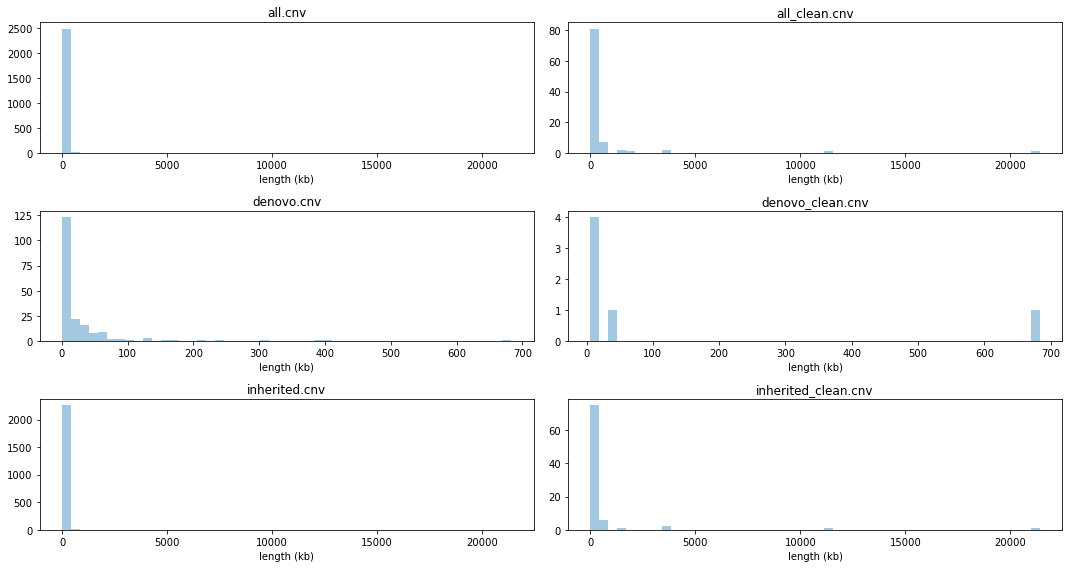

In [30]:
data_dir = '/home/sudregp/data/cnv/conifer84/'
files = glob.glob(data_dir + '/*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.tight_layout()

Not many denovos, especially in the clean section. Let's check out who has them:

In [33]:
%%bash
cd ~/data/cnv/conifer84
cat denovo_clean.cnv | awk '{ if (($5-$4)/1000 > 0) { print $_, ($5-$4)/1000 } }'

  10215   CLIA_400189    8     48695018     48701762      1            0        0  6.744
   1976   CLIA_400201   11     56258221     56294907      3            0        0  36.686
   1976   CLIA_400204   11     46878400     46884160      3            0        0  5.76
  10164   CLIA_400135    2    203149032    203157698      1            0        0  8.666
  10164   CLIA_400135   20     23017339     23030380      3            0        0  13.041
  10164   CLIA_400135   21     10215159     10898578      3            0        0  683.419


In [34]:
'CLIA_400135' in affected

False

Nothing there...

# TODO
 * Verify results using bead chip and also whole genome chip
 * Check results stability removing another family
 * Try using DNAcopy instead of threshold method
 * Try using mrsfast instead of GATK later